In [139]:
import pandas as pd
import pymysql.cursors
connection = pymysql.connect(host= 'localhost', user = 'root', password = 'Fulhamfc123$', db= 'project')
cursor = connection.cursor()
sql=('select * from Topic2')
Topic = pd.read_sql(sql, connection)

In [140]:
import os 
os.getcwd()

'C:\\Users\\HP'

In [141]:
os.chdir(r'C:\\Users\\HP')
os.getcwd()

'C:\\Users\\HP'

In [142]:
Topic.head()

,id,host_is_superhost,comments
0,163941,f,The apartment was easy to find thanks to mapqu...
1,163941,f,Terry has been absosultely wonderfull througho...
2,163941,f,"nice apartment, perfect for 4 people. clean an..."
3,163941,f,I did not had a chance to meet Terry in-person...
4,163941,f,"Terry was great! Extremely accommodating, and..."


In [143]:
Topic = pd.DataFrame(Topic)

In [146]:
Topic.head()

,id,host_is_superhost,comments
0,163941,f,The apartment was easy to find thanks to mapqu...
1,163941,f,Terry has been absosultely wonderfull througho...
2,163941,f,"nice apartment, perfect for 4 people. clean an..."
3,163941,f,I did not had a chance to meet Terry in-person...
4,163941,f,"Terry was great! Extremely accommodating, and..."


In [147]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import en_core_web_sm
nlp = en_core_web_sm.load()

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
dler = nltk.downloader.Downloader()
dler._update_index()
dler.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [148]:
data = Topic['comments'].values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:3])

['The apartment was easy to find thanks to mapquest. It was lovely, comfortable and immaculate. Very close to subway and to the Boston Museum of Fine Arts. Terry was available only by phone but ready to help and we found all we needed. Thank you. ', 'Terry has been absosultely wonderfull throughout our stay in Boston. He welcomed us, provided us with information about the citys sights and has been very attentive and easy to reach. We will defintely come back to his place again!', 'nice apartment, perfect for 4 people. clean and very well priced. also very close to the subway station (orange line). would come again!']


In [149]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'apartment', 'was', 'easy', 'to', 'find', 'thanks', 'to', 'mapquest', 'it', 'was', 'lovely', 'comfortable', 'and', 'immaculate', 'very', 'close', 'to', 'subway', 'and', 'to', 'the', 'boston', 'museum', 'of', 'fine', 'arts', 'terry', 'was', 'available', 'only', 'by', 'phone', 'but', 'ready', 'to', 'help', 'and', 'we', 'found', 'all', 'we', 'needed', 'thank', 'you']]


In [150]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['apartment be easy find thank mapquest be lovely comfortable immaculate very close subway boston museum fine art terry be available only phone ready help find need thank', 'terry have be absosultely wonderfull  stay boston welcome provide information citys sight have be very attentive easy reach will defintely come back  place again']


In [151]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [152]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.7047782615637554 %


In [153]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=5,               # Max learning iterations
                                      learning_method='batch',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [154]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -2883821.667442682
Perplexity:  578.7745163321604
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 5,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [155]:
# Define Search Param
search_params = {'n_components': [10, 15], 'learning_decay': [.5]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warnin

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15], 'learning_decay': [0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [156]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -1039922.8270174634
Model Perplexity:  648.4111187069711


In [184]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(10)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 5), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.005,0.005,0.005,0.41533,0.005,0.005,0.005,0.42021,0.005,0.12946,7
Doc1,0.00769,0.00769,0.22688,0.25245,0.09264,0.00769,0.00769,0.00769,0.11185,0.27771,9
Doc2,0.00769,0.00769,0.00769,0.00769,0.00769,0.00769,0.0077,0.44895,0.00769,0.48951,9
Doc3,0.0037,0.0037,0.17303,0.15,0.0037,0.40536,0.0037,0.24939,0.0037,0.0037,5
Doc4,0.00667,0.00667,0.00667,0.12678,0.00667,0.00667,0.00667,0.00667,0.08761,0.73894,9
Doc5,0.00417,0.00417,0.00417,0.65283,0.00417,0.00417,0.00417,0.00417,0.07969,0.23831,3
Doc6,0.0125,0.0125,0.0125,0.01251,0.0125,0.0125,0.0125,0.0125,0.0125,0.88748,9
Doc7,0.00556,0.00556,0.00556,0.00556,0.00556,0.00556,0.13653,0.52935,0.07068,0.23009,7
Doc8,0.00323,0.00323,0.235,0.04273,0.00323,0.04556,0.14258,0.00323,0.00323,0.51801,9
Doc9,0.0125,0.0125,0.0125,0.01251,0.0125,0.0125,0.0125,0.0125,0.0125,0.88749,9


In [185]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,7146
1,9,6776
2,5,1622
3,6,1444
4,8,1292
5,7,1177
6,0,496
7,4,402
8,3,399
9,1,313


In [186]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\HP\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2     -458.421692  267.846039       1        1  29.089220
9      415.063812 -280.553192       2        1  18.388049
6     -131.584061  471.685364       3        1  12.106910
8      456.626190  102.387444       4        1  10.318812
7     -499.869263 -115.055351       5        1   9.026356
5     -211.698792 -308.991394       6        1   7.618805
3       88.197380 -484.256012       7        1   6.366212
4      168.670197  296.826538       8        1   2.698216
1     -156.341019   78.449631       9        1   2.268785
0      113.214813  -90.783691      10        1   2.118634, topic_info=     Category          Freq           Term         Total  loglift  logprob
term                                                                      
1093  Default  12121.000000          great  12121.000000  30.0000  30.0000
1448  Default   7408.000000       location   7408.000000  29.0000  29.0000
1823  Default  12035.000000          place  12035.000000  28.0000  28.0000
71    Default   2094.000000        airport   2094.000000  27.0000  27.0000
2649  Default   4082.000000           walk   4082.000000  26.0000  26.0000
2090  Default   4320.000000           room   4320.000000  25.0000  25.0000
1190  Default   2712.000000           home   2712.000000  24.0000  24.0000
2320  Default  12235.000000           stay  12235.000000  23.0000  23.0000
418   Default   2915.000000          check   2915.000000  22.0000  22.0000
1997  Default   4013.000000      recommend   4013.000000  21.0000  21.0000
290   Default   8244.000000         boston   8244.000000  20.0000  20.0000
460   Default   3749.000000          close   3749.000000  19.0000  19.0000
2386  Default   1717.000000          super   1717.000000  18.0000  18.0000
780   Default   3868.000000           easy   3868.000000  17.0000  17.0000
450   Default   7376.000000          clean   7376.000000  16.0000  16.0000
1641  Default   4331.000000           nice   4331.000000  15.0000  15.0000
1203  Default   5325.000000           host   5325.000000  14.0000  14.0000
1498  Default   3284.000000           make   3284.000000  13.0000  13.0000
944   Default   2139.000000           feel   2139.000000  12.0000  12.0000
1572  Default   1929.000000         minute   1929.000000  11.0000  11.0000
224   Default   1606.000000       bathroom   1606.000000  10.0000  10.0000
1947  Default   1386.000000          quick   1386.000000   9.0000   9.0000
660   Default   2964.000000     definitely   2964.000000   8.0000   8.0000
744   Default   1629.000000       downtown   1629.000000   7.0000   7.0000
2317  Default   1504.000000        station   1504.000000   6.0000   6.0000
1945  Default   1099.000000       question   1099.000000   5.0000   5.0000
1776  Default   3170.000000        perfect   3170.000000   4.0000   4.0000
1177  Default   1649.000000         highly   1649.000000   3.0000   3.0000
2687  Default   1223.000000        welcome   1223.000000   2.0000   2.0000
502   Default   1288.000000  communication   1288.000000   1.0000   1.0000
...       ...           ...            ...           ...      ...      ...
697   Topic10    417.996625            die    418.986491   3.8520  -3.1346
1293  Topic10    303.569396            ist    304.559250   3.8511  -3.4544
2153  Topic10    294.366372           sehr    295.356226   3.8510  -3.4852
2328  Topic10    238.699384          steve    239.689312   3.8503  -3.6949
1895  Topic10    230.059437        privacy    231.049440   3.8501  -3.7317
1580  Topic10    218.806029            mit    219.795929   3.8499  -3.7819
2708  Topic10    218.126283            wir    219.116137   3.8499  -3.7850
2656  Topic10    211.586582            war    212.576436   3.8497  -3.8154
679   Topic10    208.201205            der    209.191059   3.8497  -3.8316
1502  Topic10    176.455575            man    177.445512   3.8488  -3.9970
1025  Topic10    165.300833         

In [187]:
data_frame = pd.concat([df_document_topic.reset_index(drop=True), Topic], axis=1)
del data_frame['comments']
data_frame.head()
data_frame['host_is_superhost'] = data_frame['host_is_superhost'].replace({'f': 'Host', 't': 'Superhost'})

data_compute = data_frame.groupby(['id','host_is_superhost']).agg(np.mean)
data_compute = data_compute.reset_index(level=['host_is_superhost'])
data_compute.head()

,host_is_superhost,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
id,,,,,,,,,,,,
163941,Host,0.009518,0.024626,0.267225,0.100880,0.047890,0.067451,0.074319,0.112505,0.055390,0.240197,5.227273
177129,Superhost,0.017952,0.025707,0.148242,0.036970,0.035260,0.047149,0.090663,0.088533,0.361095,0.148429,6.982249
200265,Superhost,0.023924,0.020051,0.141015,0.041526,0.049822,0.047865,0.096313,0.090768,0.325840,0.162878,6.876471
205894,Host,0.017896,0.031364,0.144264,0.047591,0.060897,0.056429,0.206800,0.125206,0.103711,0.205843,6.214660
210097,Superhost,0.027143,0.015102,0.369694,0.031554,0.022855,0.055411,0.081332,0.108756,0.107302,0.180850,4.225806


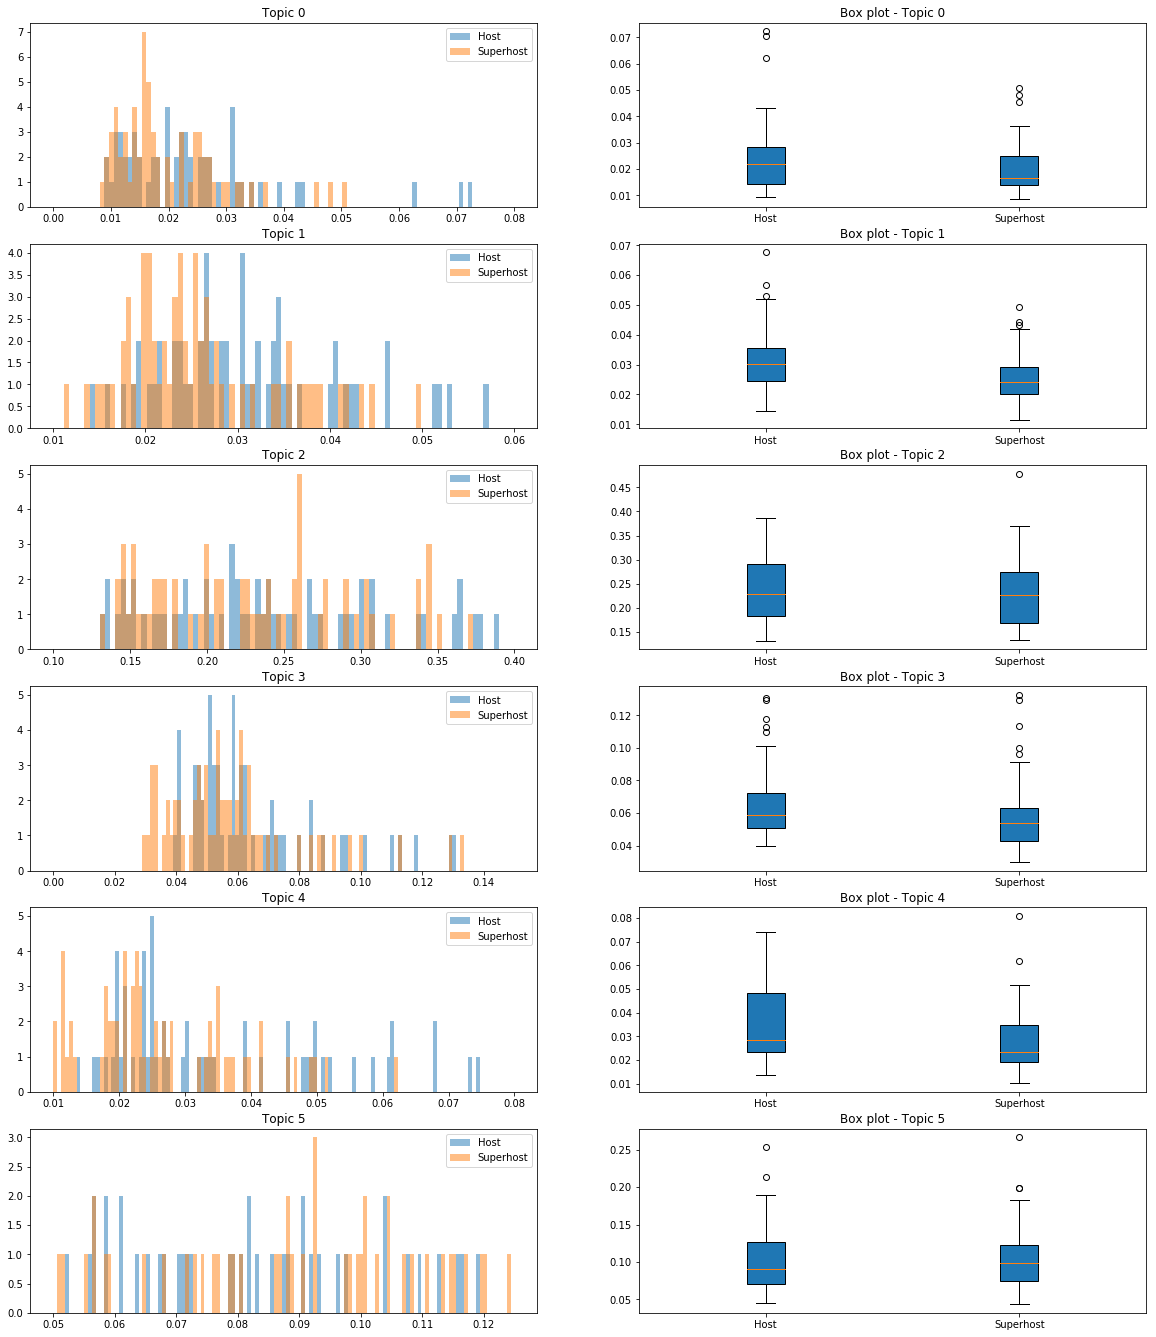

In [188]:
import matplotlib
import matplotlib.pyplot as pyplot
import numpy as numpy
fig_size[0] = 20
fig_size[1] = 40
plt.rcParams["figure.figsize"] = fig_size
############## Topic 0
pyplot.subplot(10,2,1)
l1 = []
l2 = []
l1 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic0'].values.tolist()
l2 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic0'].values.tolist()
bins = numpy.linspace(0.0, 0.08, 100)
pyplot.hist(l1, bins, alpha=0.5, label='Host')
pyplot.hist(l2, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 0",  loc='center')

#pyplot.show() 
matplotlib.pyplot.title("Topic 0",  loc='center')

pyplot.subplot(10,2,2)
box_plot_data = [l1, l2]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 0",  loc='center')
#pyplot.show() 


########## Topic 1
pyplot.subplot(10,2,3)

l3 = []
l4 = []
l3 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic1'].values.tolist()
l4 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic1'].values.tolist()
bins = numpy.linspace(0.01, 0.06, 90)
pyplot.hist(l3, bins, alpha=0.5, label='Host')
pyplot.hist(l4, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 1",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,4)
box_plot_data = [l3, l4]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 1",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
########## Topic 2
pyplot.subplot(10,2,5)

l5 = []
l6 = []
l5 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic2'].values.tolist()
l6 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic2'].values.tolist()
bins = numpy.linspace(0.1, 0.4, 90)
pyplot.hist(l5, bins, alpha=0.5, label='Host')
pyplot.hist(l6, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 2",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,6)
box_plot_data = [l5, l6]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 2",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]

################### Topic 3
pyplot.subplot(10,2,7)

l7 = []
l8 = []
l7 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic3'].values.tolist()
l8 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic3'].values.tolist()
bins = numpy.linspace(0.0, 0.15, 120)
pyplot.hist(l7, bins, alpha=0.5, label='Host')
pyplot.hist(l8, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 3",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,8)
box_plot_data = [l7, l8]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 3",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]

################### Topic 4
pyplot.subplot(10,2,9)

l8 = []
l9 = []
l8 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic4'].values.tolist()
l9 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic4'].values.tolist()
bins = numpy.linspace(0.01, 0.08, 120)
pyplot.hist(l8, bins, alpha=0.5, label='Host')
pyplot.hist(l9, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 4",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,10)
box_plot_data = [l8, l9]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 4",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]

#pyplot.show()

################### Topic 5
pyplot.subplot(10,2,11)

l10 = []
l11 = []
l10 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic5'].values.tolist()
l11 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic5'].values.tolist()
bins = numpy.linspace(0.05, 0.125, 120)
pyplot.hist(l10, bins, alpha=0.5, label='Host')
pyplot.hist(l11, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 5",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,12)
box_plot_data = [l10, l11]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 5",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]

pyplot.show()

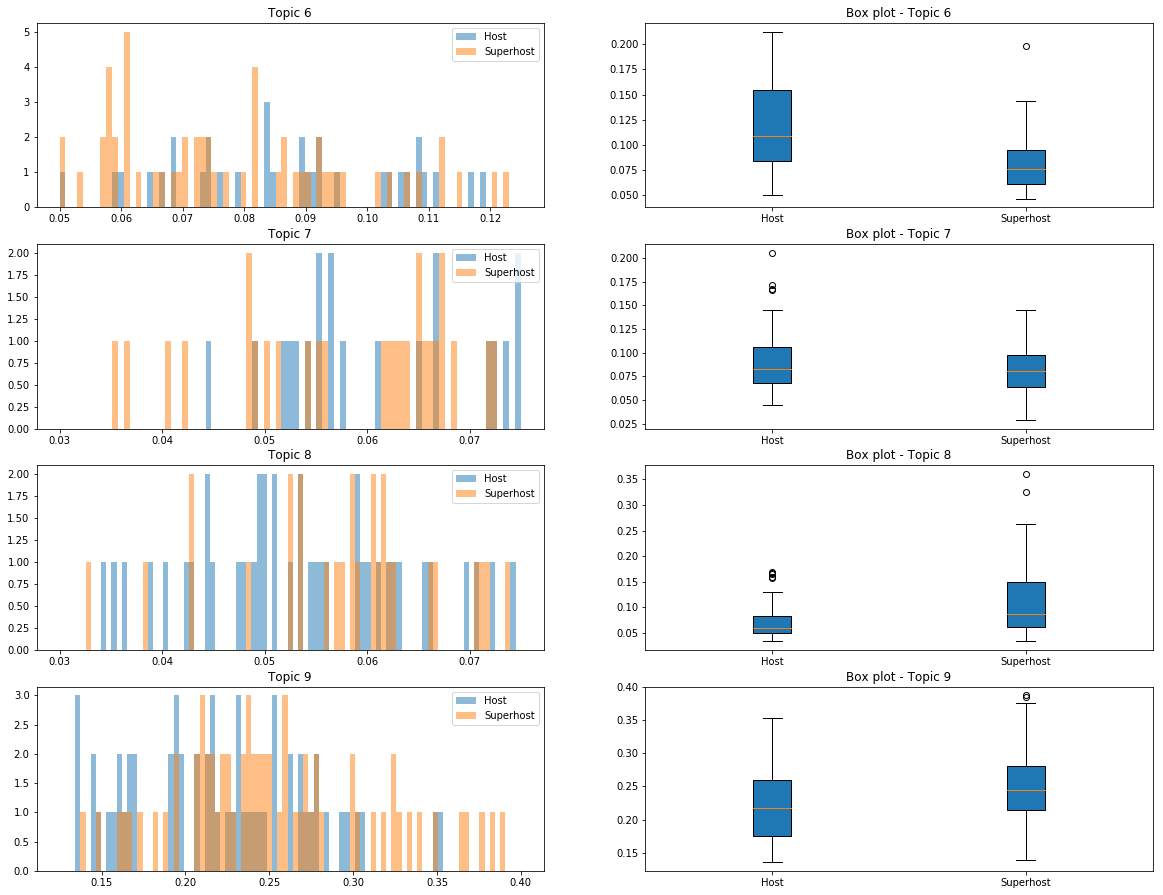

In [189]:
fig_size[0] = 20
fig_size[1] = 40
plt.rcParams["figure.figsize"] = fig_size
################### Topic 6
pyplot.subplot(10,2,13)

l12 = []
l13 = []
l12 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic6'].values.tolist()
l13 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic6'].values.tolist()
bins = numpy.linspace(0.05, 0.125, 80)
pyplot.hist(l12, bins, alpha=0.5, label='Host')
pyplot.hist(l13, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 6",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,14)
box_plot_data = [l12, l13]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 6",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]

################### Topic 7
pyplot.subplot(10,2,15)

l14 = []
l15 = []
l14 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic7'].values.tolist()
l15 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic7'].values.tolist()
bins = numpy.linspace(0.03, 0.075, 80)
pyplot.hist(l14, bins, alpha=0.5, label='Host')
pyplot.hist(l15, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 7",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,16)
box_plot_data = [l14, l15]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 7",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]

################### Topic 8
pyplot.subplot(10,2,17)

l16 = []
l17 = []
l16 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic8'].values.tolist()
l17 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic8'].values.tolist()
bins = numpy.linspace(0.03, 0.075, 90)
pyplot.hist(l16, bins, alpha=0.5, label='Host')
pyplot.hist(l17, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 8",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,18)
box_plot_data = [l16, l17]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 8",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]

################### Topic 9
pyplot.subplot(10,2,19)

l18 = []
l19 = []
l18 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic9'].values.tolist()
l19 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic9'].values.tolist()
bins = numpy.linspace(0.125, 0.4, 90)
pyplot.hist(l18, bins, alpha=0.5, label='Host')
pyplot.hist(l19, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 9",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,20)
box_plot_data = [l18, l19]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 9",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]


pyplot.show()